In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from PIL import Image

import os

In [9]:
config = {
    'batch_size'    : 4,
    'total_epochs'  : 100  ,
    'learning_rate' : 0.001,     
    'num_classes'   : 1286,    
    'input_channels': 1
}

In [10]:
transform = transforms.Compose(
[            
    transforms.ToTensor(), 
    transforms.Grayscale(),
     
    transforms.Resize((128, 128))  
    
])

train_data = ImageFolder(root='Extracted Faces/train_data', transform=transform)
test_data = ImageFolder(root='Extracted Faces/test_data', transform=transform)  

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'Extracted Faces/train_data'

In [11]:
train_data, val_data = random_split(train_data, [0.8, 0.2])  

NameError: name 'train_data' is not defined

In [23]:
train_loader = DataLoader(dataset=train_data, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=config['batch_size'], shuffle=False)

 

Нахождение среднего значения и стандартого отклонения

In [243]:

mean = torch.zeros(1)
std = torch.zeros(1)

 
for images, _ in train_loader:
    for i in range(1):   
        mean[i] += torch.mean(images[:, i, :, :])
        std[i] += torch.std(images[:, i, :, :])


mean /= len(train_loader)
std /= len(train_loader)

print("Среднее значение по каналам (RGB):", mean)
print("Стандартное отклонение по каналам (RGB):", std)


Среднее значение по каналам (RGB): tensor([0.4597])
Стандартное отклонение по каналам (RGB): tensor([0.2162])


In [12]:
class ExtractorNN(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.act = nn.LeakyReLU()
        
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)           
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
         
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, config['num_classes'])        
        
        
    def forward(self, x):  
        
        x = self.conv1(x)        
        x = self.act(x)        
        x = self.pool(x)
         
        x = self.conv2(x)         
        x = self.act(x)
        x = self.pool(x) 
         
        x = self.conv3(x)
        x = self.act(x)
        x = self.pool(x)                       
                
        x = self.flatten(x)        
        
        x = self.fc1(x)        
        x = self.act(x)        
        
        x = self.fc2(x)
        x = self.act(x)        
        
        x = self.fc3(x)         
        
        return x



In [13]:
model = ExtractorNN(config['input_channels'])

In [26]:
loss_model = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [27]:
train_loss = []
train_acc = []
val_loss =[]
val_acc = []

In [ ]:
for epoch in range(config['total_epochs']):
    model.train()
    running_train_loss = []
    true_answers = 0
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:    
        
         
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(config['num_classes'])[targets]
        
        pred = model(x)
        loss = loss_model(pred, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        
        true_answers += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
        train_loop.set_description(f'Epoch [{epoch+1}/{100}], train_loss={mean_train_loss: .4f}')
        
    running_train_acc = true_answers/len(train_data)
    
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answers = 0
        for x, targets in train_loader:             
            
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(config['num_classes'])[targets]
            pred = model(x)
            loss = loss_model(pred, targets)
        
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
        
            true_answers += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
    running_val_acc = true_answers/len(train_data)
    
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)
    
    print(f'Epoch [{epoch+1}/{1000}], train_loss={mean_train_loss: .4f}, train_acc={running_train_acc: .4f}, val_loss={mean_val_loss: .4f}, val_acc={running_val_acc: .4f}')
    

Epoch [1/1000], train_loss= 7.0399, train_acc= 0.0070, val_loss= 6.7769, val_acc= 0.0070


Epoch [2/1000], train_loss= 6.8071, train_acc= 0.0055, val_loss= 6.7446, val_acc= 0.0076


Epoch [3/1000], train_loss= 6.7895, train_acc= 0.0064, val_loss= 6.7289, val_acc= 0.0076


Epoch [4/1000], train_loss= 6.7988, train_acc= 0.0064, val_loss= 6.7313, val_acc= 0.0074


Epoch [5/1000], train_loss= 6.7691, train_acc= 0.0062, val_loss= 6.7406, val_acc= 0.0076


Epoch [6/1000], train_loss= 6.7691, train_acc= 0.0078, val_loss= 6.7202, val_acc= 0.0074


Epoch [7/1000], train_loss= 6.7639, train_acc= 0.0057, val_loss= 6.7259, val_acc= 0.0074


Epoch [8/1000], train_loss= 6.7592, train_acc= 0.0072, val_loss= 6.7233, val_acc= 0.0076


Epoch [9/100], train_loss= 6.7515:  72%|███████████████████████████████▋            | 850/1179 [01:32<00:34,  9.47it/s]

In [5]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()


NameError: name 'train_loss' is not defined

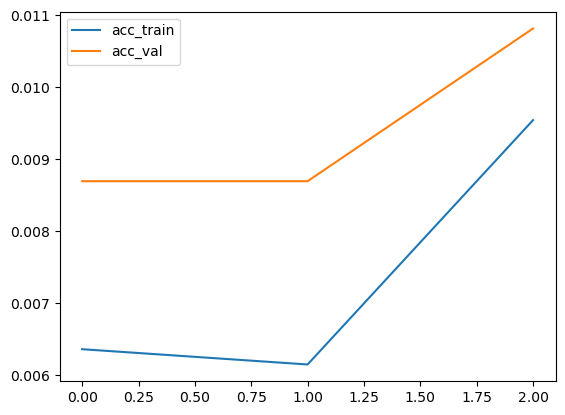

In [202]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

In [14]:
class Extractor:
    def __init__(self, model):
        self.model = model

    def transform_image(self, image_path):
        transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor(),transforms.Grayscale(),])
        
        image = transform(Image.open(image_path))
     
        image = image.unsqueeze(0)
        return image
         
         
    def get_features(self, image_path):
        image = self.transform_image(image_path)    
        
        features = model(image)         
        return features
 
 

In [16]:
extractor = Extractor(model)
print(extractor.get_features('0.jpg'))

tensor([[-0.0896,  0.0099, -0.0173,  ...,  0.0542, -0.0383,  0.0077]],
       grad_fn=<AddmmBackward0>)


In [270]:
 
def similarity_score(vector1, vector2):   
    
     
    euclidean_dist = torch.norm(vector1 - vector2, p=2)
 
    similarity = torch.exp(-euclidean_dist)
    
    return similarity 


In [241]:
print(similarity_score(features1, features2))

tensor(1.)
